<a href="https://colab.research.google.com/github/fabiomattes2016/previsor-btc-python/blob/main/Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# Conferindo libs instaladas
!pip install numpy
!pip install pandas
!pip install pandas-datareader
!pip install matplotlib
!pip install tensorflow
!pip install sklearn
!pip install scikit-learn
!pip install yfinance

In [56]:
# Importando libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import yfinance as yf
import tensorflow as tf
import os
import json
import requests
import locale

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from pandas_datareader import data as pdr

In [57]:
# Configurando as moedas
crypto_currency = ''
action_name = 'TSLA'
against_currency = 'USD'

In [58]:
# Definindo o intervalo de datas
start = dt.datetime(2016,1,1)
end = dt.datetime.now()

In [59]:
# Pegando as informações
yf.pdr_override()
if crypto_currency != "":
  data = pdr.get_data_yahoo(f'{crypto_currency}-{against_currency}', start, end)
else:
  data = pdr.get_data_yahoo(f'{action_name}', start, end)

data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,46.144001,46.276001,43.799999,44.681999,44.681999,34135500
2016-01-05,45.271999,45.377998,44.000000,44.686001,44.686001,15934000
2016-01-06,44.000000,44.009998,43.195999,43.807999,43.807999,18895500
2016-01-07,42.838001,43.688000,42.734001,43.130001,43.130001,17771500
2016-01-08,43.571999,44.088001,42.153999,42.200001,42.200001,18140500


In [60]:
# Preparando os dados
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60
future_day = 30

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data) - future_day):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x+future_day, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [61]:
# Criando a rede neural
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
42/42 [==============================] - 4s 12ms/step - loss: 0.0198
Epoch 2/25
42/42 [==============================] - 0s 10ms/step - loss: 0.0058
Epoch 3/25
42/42 [==============================] - 0s 9ms/step - loss: 0.0049
Epoch 4/25
42/42 [==============================] - 0s 9ms/step - loss: 0.0054
Epoch 5/25
42/42 [==============================] - 0s 9ms/step - loss: 0.0052
Epoch 6/25
42/42 [==============================] - 0s 10ms/step - loss: 0.0056
Epoch 7/25
42/42 [==============================] - 0s 9ms/step - loss: 0.0044
Epoch 8/25
42/42 [==============================] - 0s 9ms/step - loss: 0.0043
Epoch 9/25
42/42 [==============================] - 0s 9ms/step - loss: 0.0044
Epoch 10/25
42/42 [==============================] - 0s 10ms/step - loss: 0.0044
Epoch 11/25
42/42 [==============================] - 0s 9ms/step - loss: 0.0039
Epoch 12/25
42/42 [==============================] - 0s 10ms/step - loss: 0.0039
Epoch 13/25
42/42 [=========================

[*********************100%***********************]  1 of 1 completed


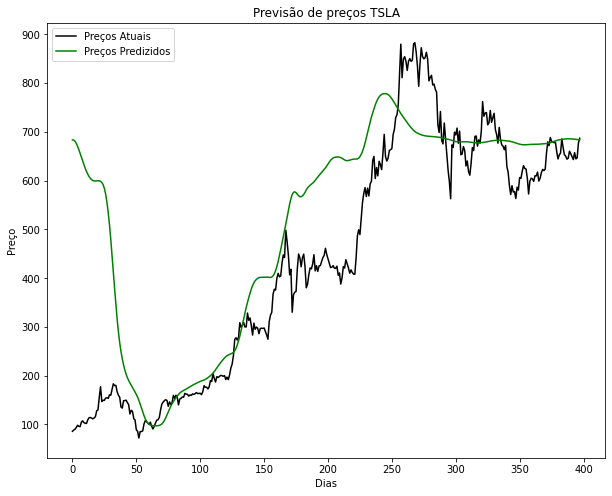

In [62]:
# Testando o modelo
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

if crypto_currency != "":
  test_data = pdr.get_data_yahoo(f'{crypto_currency}-{against_currency}', test_start, test_end)
else:
  test_data = pdr.get_data_yahoo(f'{action_name}', test_start, test_end)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append((model_inputs[x - prediction_days:x, 0]))

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

plt.figure(figsize=(10, 8))
plt.plot(actual_prices, color='black', label='Preços Atuais')
plt.plot(prediction_prices, color='green', label='Preços Predizidos')

if crypto_currency != "":
  plt.title(f'Previsão de preços {crypto_currency}/{against_currency}')
else:
  plt.title(f'Previsão de preços {action_name}')

plt.xlabel('Dias')
plt.ylabel('Preço')
plt.legend(loc='upper left')
plt.show()


In [63]:
# Predizendo o dia seguinte
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction[0][0])

683.8994


In [64]:
# Convertendo em Reais
def real_br_money_mask(my_value):
    a = '{:,.2f}'.format(float(my_value))
    b = a.replace(',','v')
    c = b.replace('.',',')
    return c.replace('v','.')

url = 'https://economia.awesomeapi.com.br/json/last/usd'
requisicao = requests.get(url)
cotacao = json.loads(requisicao.text)
preco=cotacao['USDBRL']['high']

convertido = float(prediction[0][0]) * float(preco)

locale.setlocale(locale.LC_MONETARY, 'en_US.UTF-8')
print('Cotação do dolar é ', locale.currency(float(preco)))

if crypto_currency != "":
  print(f'Previsão preço para {crypto_currency} é de R$', real_br_money_mask(float(convertido)))
else:
  print(f'Previsão preço para {action_name} é de R$', real_br_money_mask(float(convertido)))

Cotação do dolar é  $5.23
Previsão preço para TSLA é de R$ 3.575,43
